In [42]:
pip freeze > '/content/drive/MyDrive/Colab Notebooks/data_mining/hw1/requirements.txt'

In [1]:
# basic
import numpy as np
import pandas as pd
# get data
import pandas_datareader as pdr
# visual
import matplotlib.pyplot as plt
%matplotlib inline
#time
import datetime as datetime
#Prophet
from fbprophet import Prophet

from sklearn import metrics
from matplotlib import pyplot

In [2]:
# Load your cloud drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#讀取近三年每日轉備容量(2019-2021)
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_mining/hw1/近三年每日尖峰備轉容量率.csv')
data['日期'] = pd.to_datetime(data['日期'], format = "%Y/%m/%d")1
data.rename(columns = {'日期': 'ds', '備轉容量(MW)': 'y', '備轉容量率(%)': 'transferCapacity'}, inplace = True)
#data.set_index(['Adj Close'], inplace = True)
data.iloc[:,1] = data.iloc[:,1] * 10
data = data[['ds', 'y']]
data.head()

,ds,y
0,2019-01-01,2557.3
1,2019-01-02,1899.5
2,2019-01-03,1891.6
3,2019-01-04,1811.1
4,2019-01-05,1902.7


In [5]:
#讀取2022年轉備容量
data2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_mining/hw1/本年度每日尖峰備轉容量率.csv')
data2['日期'] = pd.to_datetime(data2['日期'], format = "%Y/%m/%d")
data2.rename(columns = {'日期': 'ds', '備轉容量(萬瓩)': 'y', '備轉容量率(%)': 'transferCapacity'}, inplace = True)
#data2.set_index(['Adj Close'], inplace = True)
data2.iloc[:,1] = data2.iloc[:,1] * 10
data2 = data2[['ds', 'y']]
data2.tail()

,ds,y
82,2022-03-24,2381.0
83,2022-03-25,3394.0
84,2022-03-26,3277.0
85,2022-03-27,3414.0
86,2022-03-28,3069.0


In [6]:
#合併2019-2022轉備容量
data3 = data.copy()
for i in range(len(data2)):
   data3=data3.append({'ds' : data2.loc[i, "ds"], 'y' : data2.loc[i, "y"]}, ignore_index=True)
data3

,ds,y
0,2019-01-01,2557.3
1,2019-01-02,1899.5
2,2019-01-03,1891.6
3,2019-01-04,1811.1
4,2019-01-05,1902.7
...,...,...
1178,2022-03-24,2381.0
1179,2022-03-25,3394.0
1180,2022-03-26,3277.0
1181,2022-03-27,3414.0


In [7]:
#2019-2022 只取1-4月
data4 = data[:120].copy()
for i in range(365, 486):
   data4 = data4.append({'ds' : data.loc[i, "ds"], 'y' : data.loc[i, "y"]}, ignore_index=True)
for i in range(731, 851):
   data4 = data4.append({'ds' : data.loc[i, "ds"], 'y' : data.loc[i, "y"]}, ignore_index=True)
for i in range(len(data2)):
   data4 = data4.append({'ds' : data2.loc[i, "ds"], 'y' : data2.loc[i, "y"]}, ignore_index=True)
data4

,ds,y
0,2019-01-01,2557.3
1,2019-01-02,1899.5
2,2019-01-03,1891.6
3,2019-01-04,1811.1
4,2019-01-05,1902.7
...,...,...
443,2022-03-24,2381.0
444,2022-03-25,3394.0
445,2022-03-26,3277.0
446,2022-03-27,3414.0


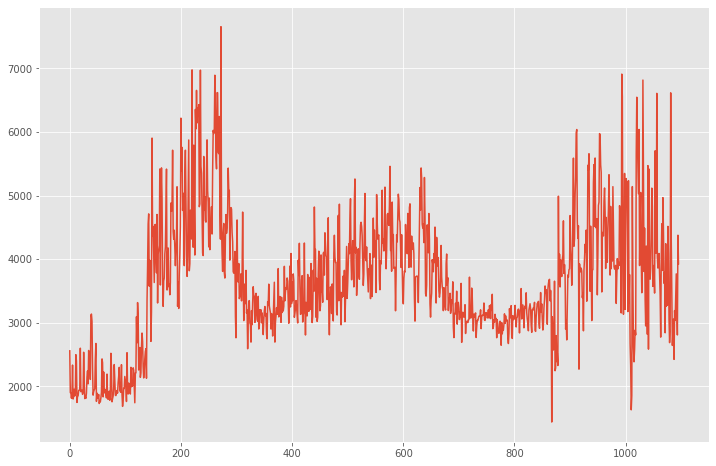

In [8]:
#觀察轉備容量分布
plt.style.use('ggplot')
data['y'].plot(figsize=(12, 8))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


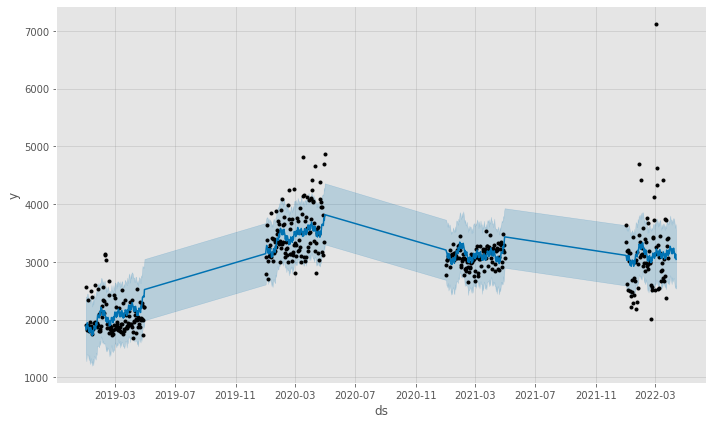

In [9]:
# data['y'] = np.log(data['y'])
# 定義模型
model = Prophet()

# 訓練模型
model.fit(data4)

# 建構預測集
future = model.make_future_dataframe(periods=16) #forecasting for 1 year from now.

# 進行預測
forecast = model.predict(future)

figure=model.plot(forecast)

In [10]:
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds         yhat   yhat_lower   yhat_upper
459 2022-04-09  3188.488496  2682.325482  3728.185618
460 2022-04-10  3141.010178  2592.560639  3667.833769
461 2022-04-11  3062.757271  2544.784652  3587.858330
462 2022-04-12  3133.137439  2592.338064  3654.207807
463 2022-04-13  3041.852607  2536.067789  3548.164643


In [15]:
#測試最後14天的RMSE
y_pred = forecast['yhat'][-30:-16]
y_true = data4['y'][-14:]
print(y_pred, y_true)
day_pred = forecast['ds'][-30:-16]
day_ture = data4['ds'][-14:]
print(day_pred, day_ture)

434    3143.905446
435    3062.217077
436    3121.824895
437    3172.182013
438    3138.273384
439    3106.933260
440    3047.465120
441    3138.541974
442    3068.986256
443    3141.014627
444    3203.480355
445    3180.770853
446    3159.150204
447    3107.403505
Name: yhat, dtype: float64 434    2986.0
435    2859.0
436    2712.0
437    4424.0
438    2675.0
439    3050.0
440    2751.0
441    3735.0
442    3717.0
443    2381.0
444    3394.0
445    3277.0
446    3414.0
447    3069.0
Name: y, dtype: float64
434   2022-03-15
435   2022-03-16
436   2022-03-17
437   2022-03-18
438   2022-03-19
439   2022-03-20
440   2022-03-21
441   2022-03-22
442   2022-03-23
443   2022-03-24
444   2022-03-25
445   2022-03-26
446   2022-03-27
447   2022-03-28
Name: ds, dtype: datetime64[ns] 434   2022-03-15
435   2022-03-16
436   2022-03-17
437   2022-03-18
438   2022-03-19
439   2022-03-20
440   2022-03-21
441   2022-03-22
442   2022-03-23
443   2022-03-24
444   2022-03-25
445   2022-03-26
446   2022-03

In [16]:
#RMSE計算
from math import sqrt
print ("MSE:",metrics.mean_squared_error(y_pred, y_true))
print ("RMSE:",sqrt(metrics.mean_squared_error(y_pred, y_true)))

MSE: 255162.74815854564
RMSE: 505.13636590384743


In [ ]:
day_pred = forecast['ds'][-91:-76]
day_pred
y_pred = forecast['yhat'][-91:-76]
y_pred

363    3024.799938
364    3093.875505
365    3009.222066
366    3083.924785
367    3107.910720
368    3060.806119
369    3010.125221
370    2941.842692
371    3000.530576
372    2913.254704
373    2992.637488
374    3027.915494
375    2997.829866
376    2968.853154
377    2925.803313
Name: yhat, dtype: float64

In [37]:
#輸出預測天數的轉備容量及日期
from datetime import datetime
answer = forecast[-15:]
answer = answer[['ds','yhat']]
answer.rename(columns = {'ds': 'date', 'yhat': 'operating_reserve(MW)'}, inplace = True)
answer.set_index('date')
for i in range(len(answer)):
  answer.iloc[i,0] = answer.iloc[i,0].strftime('%Y%m%d')
answer.to_csv('/content/drive/MyDrive/Colab Notebooks/data_mining/hw1/answer.csv',index=False)
answer

,date,operating_reserve(MW)
449,2022-03-30,3136.693275
450,2022-03-31,3208.183266
451,2022-04-01,3266.971594
452,2022-04-02,3237.467712
453,2022-04-03,3206.094964
454,2022-04-04,3141.933265
455,2022-04-05,3223.635265
456,2022-04-06,3140.214476
457,2022-04-07,3194.290172
458,2022-04-08,3235.321501
